In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import andrews_curves
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy import stats
import matplotlib.patches as mpatches
red_wine = pd.read_csv("winequality-red.csv",sep=";")
white_wine = pd.read_csv("winequality-white.csv",sep=";")
labels = ["fixed_acidity",
    "volatile_acidity",
    "citric_acid",
    "residual_sugar",
    "chlorides",
    "free_sulfur_dioxide",
    "total_sulfur_dioxide",
    "density",
    "sulphates",
    "alcohol",
    "quality"
    ]

In [21]:
#Column renaming according to usual conventions
red_wine.columns = red_wine.columns.str.replace(" ","_")
white_wine.columns = white_wine.columns.str.replace(" ","_")
red_wine["type"] = "red"
white_wine["type"] = "white"
#Categorization of quality into three groups
red_wine["quality_label"] = red_wine["quality"].apply(
    lambda value:"low" if value<=5 
        else "medium" if value<7 
        else "high"
        )
white_wine["quality_label"] = white_wine["quality"].apply(
    lambda value: "low" if value<=5
    else "medium" if value<7 
    else "high"
    )
red_wine["quality_label"] = pd.Categorical(
    red_wine["quality_label"],
    categories = [
        "low", "medium","high"
        ]
    )
white_wine["quality_label"] = pd.Categorical(
    white_wine["quality_label"],
    categories = [
        "low", "medium","high"
        ]
    )

In [22]:
white_wine.head(5)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,type,quality_label
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,white,medium
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,white,medium
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,white,medium
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,white,medium
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,white,medium


In [23]:
wines = pd.concat([red_wine,white_wine])
wines = wines.sample(
    frac=1,
    random_state=42
    ).reset_index(drop=True)

In [24]:
#FUNCTIONS

#Frequency analysis for specific feature on both types
def freq(x):
    fig,axes = plt.subplots(
        nrows=1,
        ncols=2,
        sharey=True,
        sharex=True,
        figsize=(10,4),
        facecolor="snow"
        )
    wines.hist(
        column=x,
        by="type",
        ax=axes,
        color="crimson",
        edgecolor="black",
        linewidth=1
        )
    x = x.replace("_", " ")
    x = x.capitalize()
    fig.supxlabel(x)
    x += " content in wines"
    plt.suptitle(
        x,
        x=0.5,
        y=1.05,
        ha="center",
        fontsize="x-large"
        )
    fig.supylabel("Frequency")
    axes[0].set_title("Red Wines")
    axes[1].set_title("White Wines")

#Creates a boxplot for variables xy to z of winetype dataset. 
# If out == False removes outliers
def boxplotter(x, y, z, df, out):
    fig, axes=plt.subplots(
        1, 2,
        figsize=(10,10),
        facecolor="snow"
        )
    temp = df[[z,x]]
    temp.boxplot(
        by=z,
        ax=axes[0],
        showfliers=out,
        color="dimgray"
        );axes[0].set_title("")\
            ;axes[0].set_xlabel(z);axes[0].set_ylabel(x)
    temp = df[[z,y]]
    temp.boxplot(
        by=z,
        ax=axes[1],
        showfliers=out,
        color="dimgray"
        );axes[1].set_title("")\
            ;axes[1].set_xlabel(z); axes[1].set_ylabel(y)

#Normalizes a dataset
def normalizer(df): 
    df = df.drop([
            "type", "quality_label"
            ],
        axis=1
        )
    scaler = MinMaxScaler()
    scaler.fit(df)
    scaled = scaler.fit_transform(df)
    scaled_df = pd.DataFrame(scaled, columns=df.columns)
    return scaled_df

#Takes a,b variables for x and y axis respectively; 
# nor is a boolean value for normalization
def plotter(i, j, df1, df2, nor):
    if nor:
        df1 = normalizer(df1)
        df2 = normalizer(df2)
    fig, axes = plt.subplots(
        1, 2,
        figsize=(14,7),
        facecolor="snow"
        )
    i = sns.regplot(
        ax=axes[0],
        x=df1[i],
        y=df1[j],
        lowess=True,
        scatter_kws = {
            "color": "crimson"
            },
        line_kws = {
            "color": "black"
            }
        )
    j = sns.regplot(
        ax=axes[1],
        x=df2[i],
        y=df2[j],
        lowess=True,
        scatter_kws={
            "color": "crimson"
            },
        line_kws={
            "color": "black"
            }
        )
    return i,j

#Graphs relationship between x,y variables on df dataset
def rel_check(x, y, df):
    gg = sns.JointGrid(
        x=x,
        y=y,
        data=df
        )
    x_lab = x.replace("_", " ").capitalize()
    y_lab = y.replace("_", " ").capitalize()
    gg = gg.plot_joint(
        sns.regplot,
        color="crimson"
        )
    gg = gg.plot_marginals(
        sns.histplot,
        kde=True,
        color="goldenrod"
        )
    gg.set_axis_labels(x_lab, y_lab)
    return gg

#Multigraphs kde,scatter and hist for all variables (It takes time)
def exp(df):
    pp = sns.PairGrid(df)
    pp = pp.map_upper(
        sns.kdeplot,
        cmap="hot",
        shade=True,
        thresh=False
        )
    pp = pp.map_diag(
        plt.hist,
        color="darkgrey"
        )
    pp = pp.map_lower(
        sns.scatterplot,
        color="crimson",
        edgecolor="black"
        )
    return pp

#Used for the removal of outliers with quantile principle
def correction(df):
    df = df[labels]
    sorted(df)
    for i in df:
        q1 = df[i].quantile(0.25)
        q3 = df[i].quantile(0.75)
        iqr = q3 - q1
        low = q1 - 1.5*iqr
        high = q3 + 1.5*iqr 
        df = df.loc[
            (df[i]>low)
            & (df[i]<high)
            ]
    return df

#Multivariate analysis with x,y features of df dataset, with quality label hue
def multivariate(x, y, df):
    colors = {
        "low": "yellow",
        "medium": "crimson",
        "high": "black"
        }
    fig,axes = plt.subplots(
        figsize=(12,8),
        facecolor="snow"
        )
    scatter = axes.scatter(
        df[x],
        df[y],
        c=df["quality_label"].map(colors),
        alpha=0.5
        )
    x = x.replace("_", " ").capitalize() + ", "
    axes.set_xlabel(x, fontsize=10)
    y = y.replace("_", " ") + " "
    axes.set_ylabel(y, fontsize=10)
    if len(df["type"].unique()) == 2: 
        title = "Wines"
    elif 1 in df["type"].unique(): 
        title = "Red wines"
    else: 
        title = "White wines" 
    axes.set_title(
        title + " - "
        + x
        + y
        + "and quality"
        )
    low_quality = mpatches.Patch(
        color="yellow",
        label = "Low quality wines"
        )
    medium_quality = mpatches.Patch(
        color="crimson",
        label = "Medium quality wines"
        )
    high_quality = mpatches.Patch(
        color="black",
        label = "Higher quality wines"
        )
    axes.legend(
        handles = [
            low_quality,
            medium_quality,
            high_quality
            ]
        )
    plt.show()

Fixed acidity refers to tartaric acid, the primary acid taste in wine, essential to mouthfeel and balance, adding an additional complexity to wine.
Citric acid is the fruity flavour. Adds some acidity, used less frequently due to the strong flavour and tendecy to break down to vinegar/ethanol. 
Volatile acidity is the gaseous acidic elements of a wine. Creates a vinegar/nail polish remover smell. Usualy undesirable

Only pH seems to have normal distribution. All other values are positely/right skewed
Removal of outliers for all except pH should be done with IQR-distance filter

Alcohol is the strongest indicator of a good quality wine, irrespective of type
For red wines, simmilary strong indicator is volatile acidity, inversely propotionate with quality
Sulphates and citric acid also have a small positive correlation
For white wines, apart from alcohol, the strongest indicators are chlorides, volatile acidity and total SO2, all inversely propotiional to quality
For the compined dataset, strong features are alcohol(+), volatile acidity(-) and chlorides(-)

Some coupling between features are:
(Free SO2-Total SO2) (Alcohol-Density)
(Total SO2-Residual sugar) (Density-Residual sugar)

We elected to not use density, as it is a property of the wine's composition

Checking the skewness of the variables

In [28]:
%%script False
for i in white_wine.columns:
    sns.displot(white_wine[i], kde=True)
    plt.title(i)
    plt.show()

Couldn't find program: 'False'


In [29]:
%%script False
for i in red_wine.columns:
    sns.displot(red_wine[i], kde=True)
    plt.title(i)
    plt.show()

Couldn't find program: 'False'


In [30]:
#ANOVA
%%script False
f, p = stats.f_oneway(
    wines[wines["quality_label"] == "low"]["alcohol"],
    wines[wines["quality_label"] == "medium"]["alcohol"],
    wines[wines["quality_label"] == "high"]["alcohol"]
    )
print("ANOVA test for mean alcohol level across"\
    " wine samples with different quality ratings"
    )
print(
    "F Statistic:", f, "\tp-value:", p
    )

UsageError: Line magic function `%%script` not found.


In [31]:
conr = red_wine.describe(
    ).applymap("{:.2f}".format)
conw = white_wine.describe(
    ).applymap("{:.2f}".format)
keys = ["Red Whine Statistics", "White Wine Statistics"]
wines_sum = pd.concat(
    (conr,conw),
    axis=0, 
    keys=keys
    )
del conr, conw, keys
wines_sum

fixed_acidity volatile_acidity citric_acid  \
Red Whine Statistics  count       1599.00          1599.00     1599.00   
                      mean           8.32             0.53        0.27   
                      std            1.74             0.18        0.19   
                      min            4.60             0.12        0.00   
                      25%            7.10             0.39        0.09   
                      50%            7.90             0.52        0.26   
                      75%            9.20             0.64        0.42   
                      max           15.90             1.58        1.00   
White Wine Statistics count       4898.00          4898.00     4898.00   
                      mean           6.85             0.28        0.33   
                      std            0.84             0.10        0.12   
                      min            3.80             0.08        0.00   
                      25%            6.30             0.21        0.27   
                      50%            6.80             0.26        0.32   
                      75%            7.30             0.32        0.39   
                      max           14.20             1.10        1.66   

                            residual_sugar chlorides free_sulfur_dioxide  \
Red Whine Statistics  count        1599.00   1599.00             1599.00   
                      mean            2.54      0.09               15.87   
                      std             1.41      0.05               10.46   
                      min             0.90      0.01                1.00   
                      25%             1.90      0.07                7.00   
                      50%             2.20      0.08               14.00   
                      75%             2.60      0.09               21.00   
                      max            15.50      0.61               72.00   
White Wine Statistics count        4898.00   4898.00             4898.00   
                      mean            6.39      0.05               35.31   
                      std             5.07      0.02               17.01   
                      min             0.60      0.01                2.00   
                      25%             1.70      0.04               23.00   
                      50%             5.20      0.04               34.00   
                      75%             9.90      0.05               46.00   
                      max            65.80      0.35              289.00   

                            total_sulfur_dioxide  density       pH sulphates  \
Red Whine Statistics  count              1599.00  1599.00  1599.00   1599.00   
                      mean                 46.47     1.00     3.31      0.66   
                      std                  32.90     0.00     0.15      0.17   
                      min                   6.00     0.99     2.74      0.33   
                      25%                  22.00     1.00     3.21      0.55   
                      50%                  38.00     1.00     3.31      0.62   
                      75%                  62.00     1.00     3.40      0.73   
                      max                 289.00     1.00     4.01      2.00   
White Wine Statistics count              4898.00  4898.00  4898.00   4898.00   
                      mean                138.36     0.99     3.19      0.49   
                      std                  42.50     0.00     0.15      0.11   
                      min                   9.00     0.99     2.72      0.22   
                      25%                 108.00     0.99     3.09      0.41   
                      50%                 134.00     0.99     3.18      0.47   
                      75%                 167.00     1.00     3.28      0.55   
                      max                 440.00     1.04     3.82      1.08   

                             alcohol  quality  
Red Whine Statistics  count  1599.00  1599.00  
                   

<AxesSubplot:title={'center':'Distribution of wines based on colour'}, ylabel='Wine type'>

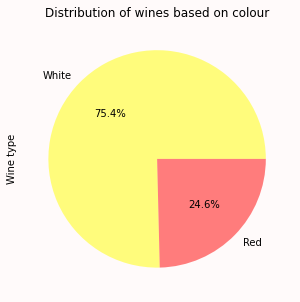

In [32]:
fig = plt.subplots(
    figsize=(5,5),
    facecolor="snow"
    )
labels = ["White", "Red"]
wines["type"].value_counts().plot(
    kind="pie", 
    autopct="%.1f%%",
    labels=labels,
    wedgeprops={"alpha":0.5},
    colors=["yellow","red"],
    ylabel = "Wine type",
    title = "Distribution of wines based on colour"
    )

Text(0.5, 0, 'Wine quality')

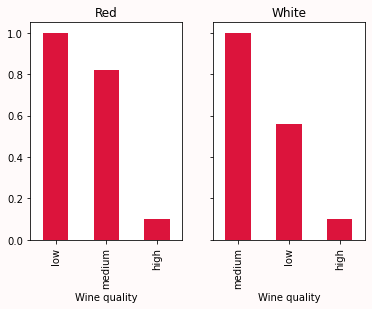

In [33]:
tempr = pd.DataFrame(
    data = {
        "quality_label": [
            "low", "medium", "high"
            ],
        "count": red_wine.value_counts(
            subset = "quality_label"
            )
        }
    )
tempw = pd.DataFrame(
    data = {
        "quality_label": [
            "low", "medium", "high"
            ],
        "count": white_wine.value_counts(
            subset = "quality_label"
            )
        }
    )
#Normalized for better understanding due to the 
# radically different dataframe sizes
fig, axes = plt.subplots(
    1,2,
    sharey=True,
    squeeze=True,
    facecolor="snow"
    )
tempr["count"] = preprocessing.minmax_scale(
    tempr["count"], 
    feature_range=(0.1, 1)
    )
tempw["count"] = preprocessing.minmax_scale(
    tempw["count"],
    feature_range=(0.1, 1)
    )
tempr["count"].plot(
    kind='bar',
    ax=axes[0],
    color=["crimson"]
    ); axes[0].set_title('Red'); axes[0].set_xlabel("Wine quality")
tempw["count"].plot(
    kind='bar',
    ax=axes[1],
    color=["crimson"]
    ); axes[1].set_title('White'); axes[1].set_xlabel("Wine quality")

Text(0.65, 1.25, 'Red wine univariate plots')

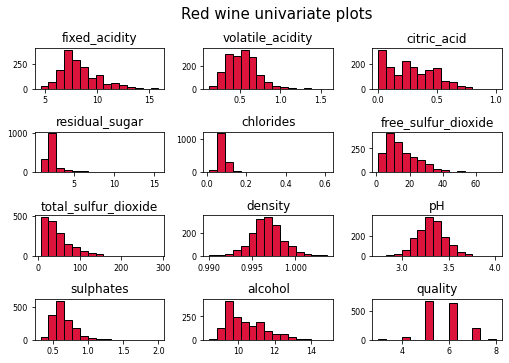

In [34]:
#Univariate frequency analysis for red wines
red_wine.hist(
    bins=15,
    color="crimson",
    edgecolor="black",
    linewidth=1,
    xlabelsize=8,
    ylabelsize=8,
    grid=False
    )
plt.tight_layout(rect=(0,0,1.2,1.2))
plt.suptitle(
    "Red wine univariate plots",
    x=0.65,
    y=1.25,
    fontsize=15
    )

Text(0.65, 1.25, 'White wine univariate plots')

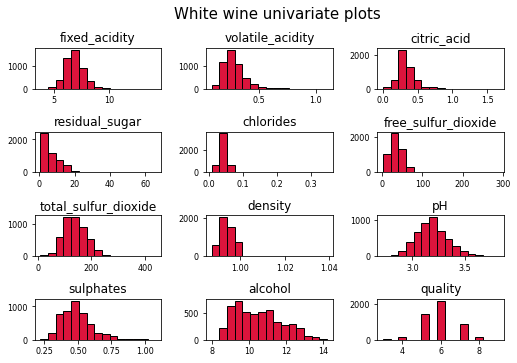

In [35]:
#Univariate frequency analysis for white wines
white_wine.hist(
    bins=15,
    color="crimson",
    edgecolor="black",
    linewidth=1,
    xlabelsize=8,
    ylabelsize=8,
    grid=False
    )
plt.tight_layout(rect=(0,0,1.2,1.2))
plt.suptitle(
    "White wine univariate plots",
    x=0.65,
    y=1.25,
    fontsize=15
    )

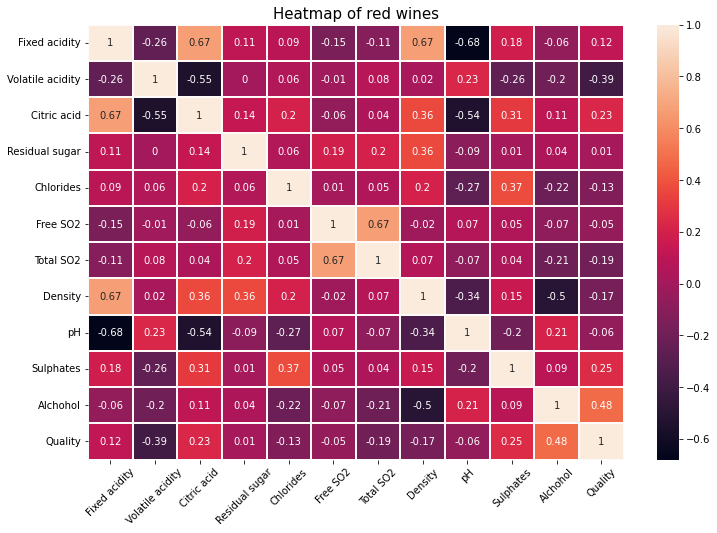

,quality
quality,1.000000
alcohol,0.476166
sulphates,0.251397
citric_acid,0.226373
fixed_acidity,0.124052
residual_sugar,0.013732
free_sulfur_dioxide,-0.050656
pH,-0.057731
chlorides,-0.128907
density,-0.174919


In [36]:
#Heatmap for red wines
labels = [
    "Fixed acidity",
    "Volatile acidity",
    "Citric acid",
    "Residual sugar",
    "Chlorides",
    "Free SO2",
    "Total SO2",
    "Density",
    "pH",
    "Sulphates",
    "Alchohol",
    "Quality"
    ]
plt.figure(figsize=(12,8))
sns.heatmap(
    red_wine.corr().round(2),
    color="k",
    linecolor="snow",
    linewidth=0.2,
    annot=True,
    yticklabels=labels,
    xticklabels=labels
    )
plt.xticks(rotation=45)
plt.title("Heatmap of red wines", fontsize=15)
plt.show()
red_wine.corr()[["quality"]].sort_values(by="quality",ascending=False)

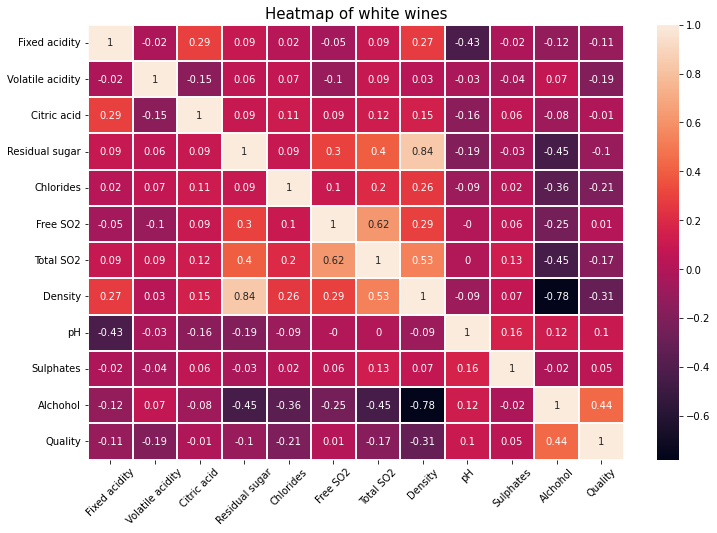

,quality
quality,1.000000
alcohol,0.435575
pH,0.099427
sulphates,0.053678
free_sulfur_dioxide,0.008158
citric_acid,-0.009209
residual_sugar,-0.097577
fixed_acidity,-0.113663
total_sulfur_dioxide,-0.174737
volatile_acidity,-0.194723


In [37]:
#Heatmap for white wines
plt.figure(figsize=(12,8))
sns.heatmap(
    white_wine.corr().round(2),
    color="k",
    linecolor="snow",
    linewidth=0.2,
    annot=True,
    yticklabels=labels,
    xticklabels=labels
    )
plt.xticks(rotation=45)
plt.title("Heatmap of white wines", fontsize=15)
plt.show()
white_wine.corr()[["quality"]].sort_values(by="quality",ascending=False)

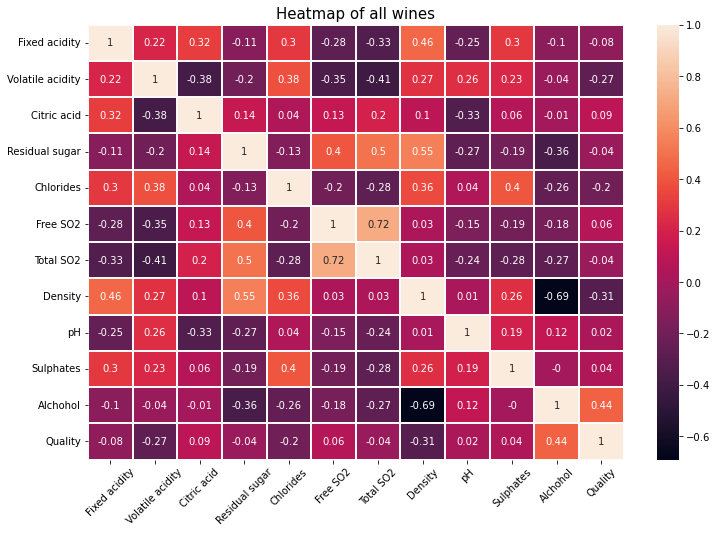

,quality
quality,1.000000
alcohol,0.444319
citric_acid,0.085532
free_sulfur_dioxide,0.055463
sulphates,0.038485
pH,0.019506
residual_sugar,-0.036980
total_sulfur_dioxide,-0.041385
fixed_acidity,-0.076743
chlorides,-0.200666


In [38]:
#Heatmap for all wines
plt.figure(figsize=(12,8))
sns.heatmap(
    wines.corr().round(2),
    color="k",
    linecolor="snow",
    linewidth=0.2,
    annot=True,
    yticklabels=labels,
    xticklabels=labels
    )
plt.xticks(rotation=45)
plt.title("Heatmap of all wines", fontsize=15)
plt.show()
#Alcohol, volatile acidity, density and chlorides influence a wine's quality
wines.corr()[["quality"]].sort_values(by="quality",ascending=False)

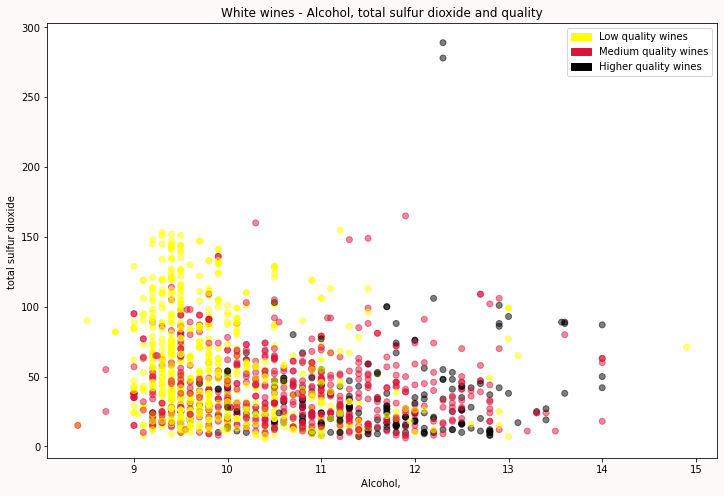

In [39]:
multivariate("alcohol", "total_sulfur_dioxide", red_wine)

In [40]:
#exp(wines)

In [41]:
#exp(wines[["alcohol","free_sulfur_dioxide","volatile_acidity","chlorides"]])

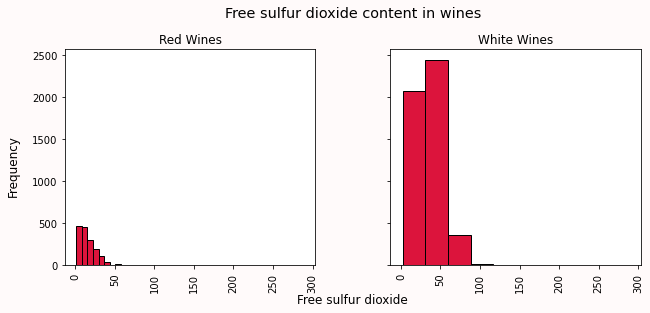

In [42]:
freq("free_sulfur_dioxide")

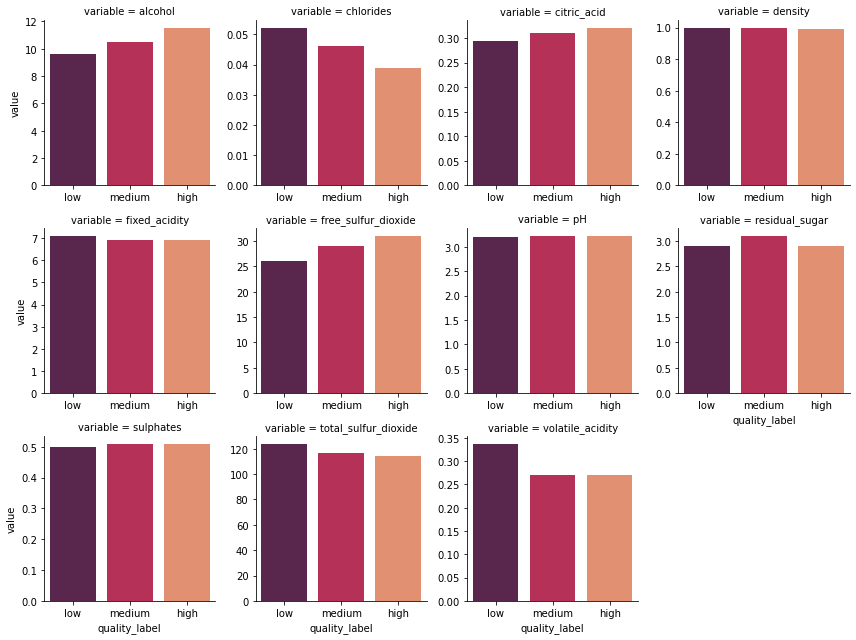

In [43]:
#Create a new dataframe g1, with quality and quality label columns serving as identifiers
temp = wines[
        ["fixed_acidity",
        "volatile_acidity",
        "citric_acid",
        "residual_sugar",
        "chlorides",
        "free_sulfur_dioxide",
        "total_sulfur_dioxide",
        "density",
        "pH",
        "sulphates",
        "alcohol",
        "quality",
        "quality_label"
        ]
    ]
g1 = pd.melt(
    temp,
    id_vars=["quality","quality_label"],
    value_vars=temp.columns,
    var_name="variable",
    value_name="value"
    )
g1.sort_values(
    by=["variable","quality"],
    ascending=[True,True],
    inplace=True
    )
g1.reset_index(drop=True, inplace=True)
g1.quality = g1.quality.astype("str")
g1.quality = g1.quality.astype("category")
#Create histplots for every variable binned by quality label
g1 = g1.groupby(
    by=["variable","quality_label"],
    as_index=False
    )[["value"]].median()
pp = sns.FacetGrid(
    g1,
    col="variable",
    col_wrap=4,
    sharey=False,
    sharex=False,
    height=3,
    aspect=1,
    hue="quality_label",
    hue_order = ["low","medium","high"],
    palette="rocket"
    )
pp.map(
    sns.barplot,
    "quality_label",
    "value",
    order = ["low","medium","high"]
    )
plt.show()

In [44]:
#Having done all that we can check the correlation for each pair of significant value to quality

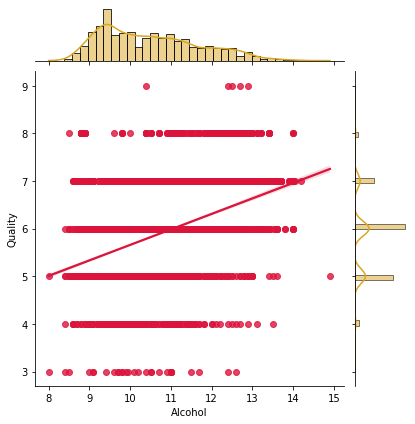

In [45]:
rel_check("alcohol", "quality", wines)

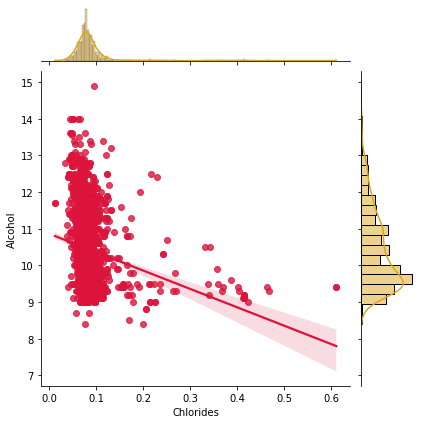

In [46]:
rel_check("chlorides", "alcohol", red_wine)

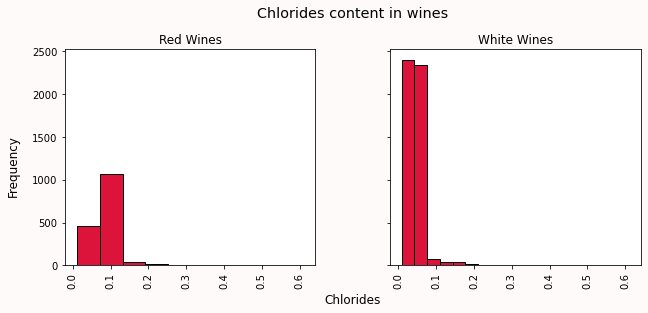

In [47]:
freq("chlorides")

Text(0.5, 1.0, 'Distribution according to quality label')

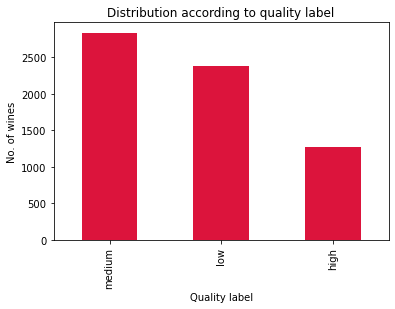

In [48]:
tempr = pd.DataFrame(
    data = {
        "quality_label": [
            "low","medium","high"
            ],
        "count": wines.value_counts(
            subset="quality_label"
            )
        }
    )
#Normalized for better understanding due to the radically different dataframe sizes
fig, axes = plt.subplots(squeeze=True)
# tempr["count"] = preprocessing.minmax_scale(
#     tempr["count"], 
#     feature_range=(0.1, 1)
#     )
tempr["count"].plot(
    kind='bar',
    color=["crimson"]
    )
axes.set_xlabel("Quality label")
axes.set_ylabel("No. of wines")
axes.set_title("Distribution according to quality label")